In [117]:
import os
os.chdir("/Users/praveen/MSDS/Data_Science_Practicum/FinGlobe_Project/FinGlobeModule/")
os.getcwd()

'/Users/praveen/MSDS/Data_Science_Practicum/FinGlobe_Project/FinGlobeModule'

In [118]:
# !pip install openai

In [119]:
import os, re, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (9,4)
print("CWD :", os.getcwd())

# Paths
MODEL_OUT_PATH = "/Users/praveen/MSDS/Data_Science_Practicum/FinGlobe_Project/FinGlobeModule/cache/model_output/20251020_185529_score[-1_to_+1].json"
MINUTES_PATH   = "/Users/praveen/MSDS/Data_Science_Practicum/FinGlobe_Project/FinGlobeModule/cache/scrapped_data/mpc_minutes_20200101_20241231.json"

from src.mcp_project.tools.stance_scorer_eda import score_all



CWD : /Users/praveen/MSDS/Data_Science_Practicum/FinGlobe_Project/FinGlobeModule


In [120]:
# --- load aggregated output (mean/std from file) ---
with open(MODEL_OUT_PATH, "r", encoding="utf-8") as f:
    agg_raw = json.load(f)

rows = []
for d, v in agg_raw.items():
    agg = v.get("Aggregated_output", {})
    rows.append({
        "date": d,
        "mean": agg.get("mean"),
        "std": agg.get("std_dev"),
        "stance": agg.get("stance"),
        "kw_counts": agg.get("kw_counts"),
        "rationale": agg.get("rationale"),
    })

# compute hawkish/dovish scores via your stance_scorer.py
- insight: explain ensemble mean (tone) and σ (model uncertainty/dispersion).

In [121]:
df_score = (pd.DataFrame(rows)
            .assign(date=lambda x: pd.to_datetime(x["date"], errors="coerce"))
            .dropna(subset=["date"])
            .sort_values("date").reset_index(drop=True))

# --- load texts (for word_count / regex features) ---
with open(MINUTES_PATH, "r", encoding="utf-8") as f:
    texts = json.load(f)  # {date: text}
df_text = (pd.DataFrame(list(texts.items()), columns=["date","text"])
           .assign(date=lambda d: pd.to_datetime(d["date"], errors="coerce"))
           .dropna(subset=["date"])
           .sort_values("date")
           .reset_index(drop=True))

# optional window (e.g., last 3y)
cutoff = df_text["date"].max() - pd.DateOffset(years=4)
df_text = df_text[df_text["date"] >= cutoff].copy()

# --- merge ---
df = df_text.merge(df_score, on="date", how="left")
df["word_count"] = df["text"].str.split().str.len()






# Parse factual policy cues from the text
- Goal: extract Bank Rate, CPI(Consumer Price Index), and decision (cut/hold/hike) with light regex.
- Insight: this anchors tone to observable policy context (rate level, CPI, action).

#### Misc:
CPI measures inflation — the percentage change in average prices of goods and services over time.

#### Why it matters:
- The BoE’s target = 2% CPI inflation.
- So, whenever CPI is above 2%, the MPC’s tone tends to be hawkish (concerned about overheating).
- When CPI falls below 2%, tone leans dovish (worrying about weak demand or disinflation).

#### Bank Rate
##### Definition: The official policy interest rate set by the Bank of England’s Monetary Policy Committee (MPC).
It’s the rate the BoE pays commercial banks on reserves — effectively the anchor for short-term borrowing costs in the economy.

#### Why it matters:
- It’s the primary policy instrument used to tighten or loosen monetary conditions.
- When the MPC raises the Bank Rate, it signals hawkish (anti-inflation) stance.
- When it cuts the rate, it signals dovish (growth-supportive) stance.
- Holding steady usually indicates a neutral or “wait-and-see” approach.

#### Insight use: 
Lets you test: Does the LLM’s hawkish tone rise before rate hikes? (which would validate it captures forward guidance).

# Decision (cut / hold / hike)
##### Definition:
The MPC’s action outcome at each meeting — whether it raised, cut, or held the Bank Rate.

#### Why it matters:
- It’s the single clearest indicator of policy stance:
- Hike → tightening → hawkish.
- Cut → easing → dovish.
- Hold → neutral / wait-and-see.

#### Insight use:
Helps validate if your LLM’s tone classification aligns with actual MPC actions.

#### For example:
If the LLM’s mean score is highest in “hike” meetings and lowest in “cut” ones, the model is interpreting tone realistically.

In [122]:
def find_rate(t):
    m = re.search(r'Bank Rate.*?(?:to|at)\s*([0-9.]+)\s*%', t or "", re.I)
    return float(m.group(1)) if m else np.nan

def find_cpi(t):
    m = re.search(r'CPI inflation.*?([0-9.]+)\s*%', t or "", re.I)
    return float(m.group(1)) if m else np.nan

def find_decision(t):
    s = t or ""
    if re.search(r'\b(increase|raise)\b', s, re.I): return "hike"
    if re.search(r'\b(reduce|cut|lower)\b', s, re.I): return "cut"
    if re.search(r'\b(maintain|keep|hold)\b', s, re.I): return "hold"
    return "unknown"

df["bank_rate"] = df["text"].apply(find_rate)
df["cpi"]       = df["text"].apply(find_cpi)
df["decision"]  = df["text"].apply(find_decision)


# Track uncertainty & verbosity
- Goal: quick proxies for policy hesitation and communication intensity.
- Insight: spikes in uncertainty words and longer statements often coincide with close votes or regime shifts.

In [123]:
UNC = r"(uncertainty|risk|volatile|monitor|tension|shock|geopolitical)"
df["uncert_count"] = df["text"].str.count(UNC, flags=re.I)


# Goal: show tone trajectory, uncertainty, and length over meetings.
#### insight:
- Mean up = hawkish shift; down = dovish shift.
- σ up = ambiguous/contested guidance.
- Uncertainty/length up = caution around policy turning points.

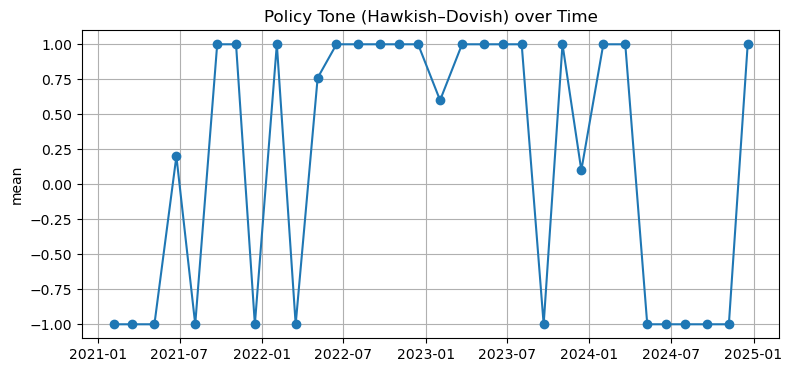

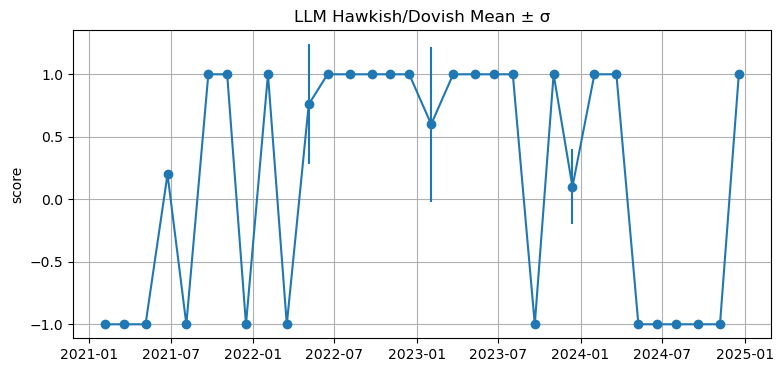

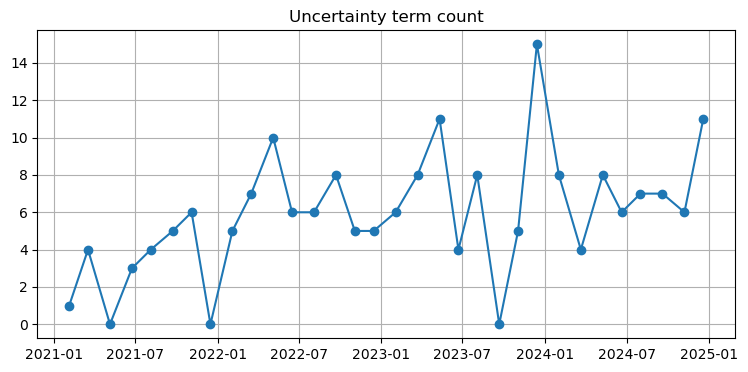

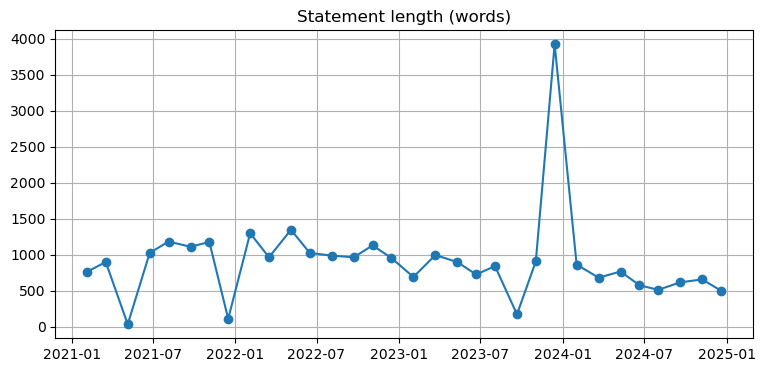

In [124]:
# --- plots (std already comes from Aggregated_output) ---
plt.plot(df["date"], df["mean"], marker="o"); plt.title("Policy Tone (Hawkish–Dovish) over Time"); plt.ylabel("mean"); plt.grid(True); plt.show()
plt.errorbar(df["date"], df["mean"], yerr=df["std"], fmt="o-"); plt.title("LLM Hawkish/Dovish Mean ± σ"); plt.ylabel("score"); plt.grid(True); plt.show()

plt.plot(df["date"], df["uncert_count"], marker="o"); plt.title("Uncertainty term count"); plt.grid(True); plt.show()
plt.plot(df["date"], df["word_count"], marker="o"); plt.title("Statement length (words)"); plt.grid(True); plt.show()


# Insights:

## 1. Policy Tone (Hawkish–Dovish) over Time:
The chart shows that the Bank of England’s policy tone swings sharply between dovish (–1) and hawkish (+1) phases, indicating strong shifts in sentiment across meetings.

Periods like 2022–2023 were mostly hawkish, reflecting tightening bias, while mid-2024 shows a return to dovish tones—suggesting softer policy communication or easing outlook.

## 2. LLM Hawkish/Dovish Mean ± σ (Tone & Uncertainty):

This chart shows how confidently the LLM assessed each meeting’s tone.
Periods like 2022–2023 have strong hawkish scores (+1) with low uncertainty, while mid-2024 shows more dovish (–1) or mixed tones with higher variance — suggesting more ambiguous or shifting policy communication.


## 3. Uncertainty term count:

This chart shows that uncertainty-related terms (like risk, volatile, shock) increased notably from 2022 onward, peaking around early 2024 — suggesting heightened policy or economic uncertainty during that period.
It implies the central bank’s communication became more cautious and risk-aware over time.

## 4. Statement length (words):
This chart shows that statement lengths were generally stable (around 800–1200 words) except for a sharp spike in early 2024, where the word count nearly quadrupled.
That surge likely reflects an unusually detailed or complex policy communication, possibly explaining or defending a major decision or economic shift.

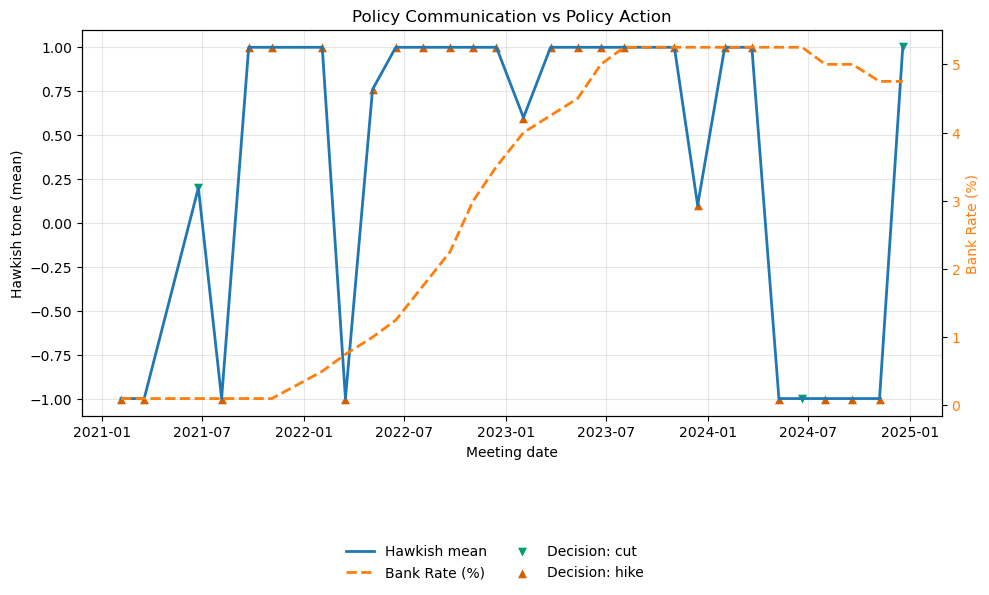

In [135]:
# ==== Combined view ====
d = df.dropna(subset=["mean","bank_rate","decision"]).copy().sort_values("date")
cmap   = {"hike":"#D55E00", "hold":"#0072B2", "cut":"#009E73", "unknown":"#999999"}
marks  = {"hike":"^", "hold":"o", "cut":"v", "unknown":"x"}

fig, ax1 = plt.subplots(figsize=(10,4.8))
ax1.plot(d["date"], d["mean"], lw=2, label="Hawkish mean", zorder=2)
ax1.set_ylabel("Hawkish tone (mean)"); ax1.set_xlabel("Meeting date"); ax1.grid(True, alpha=0.3)
ax2 = ax1.twinx()
ax2.plot(d["date"], d["bank_rate"], "--", lw=2, label="Bank Rate (%)", color="tab:orange", zorder=1)
ax2.set_ylabel("Bank Rate (%)", color="tab:orange"); ax2.tick_params(axis='y', labelcolor="tab:orange")
for dec, sub in d.groupby("decision"):
    ax1.scatter(sub["date"], sub["mean"], s=60, color=cmap.get(dec,"#999"), marker=marks.get(dec,"o"),
                edgecolor="white", linewidth=0.8, label=f"Decision: {dec}")

h1, l1 = ax1.get_legend_handles_labels()  # from Hawkish + decisions
h2, l2 = ax2.get_legend_handles_labels()  # from Bank Rate

# reorder for custom grouping
handles = [h1[0], h2[0], h1[1], h1[2]]  # Hawkish mean, Bank Rate, Decision:hike, Decision:cut
labels  = [l1[0], l2[0], l1[1], l1[2]]

# 2 columns × 2 rows layout
fig.legend(handles, labels,
           ncol=2, loc="upper center", bbox_to_anchor=(0.5, -0.12),
           columnspacing=1.5, frameon=False)

plt.title("Policy Communication vs Policy Action")
plt.tight_layout()
plt.show()


# Insights
The chart shows that the hawkish tone in policy communication (blue line) closely tracked periods when the Bank Rate (orange line) was rising between 2022–2023, indicating tightening sentiment.
After mid-2023, both the tone and rate stabilized or turned dovish, suggesting a shift toward policy caution as economic conditions softened.

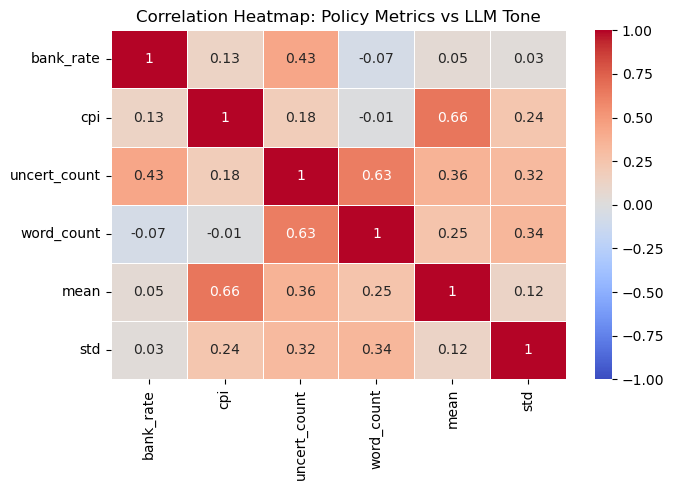

In [136]:
# --- correlations (optional; requires seaborn installed) ---
import seaborn as sns
num = df[["bank_rate", "cpi", "uncert_count", "word_count", "mean", "std"]]
corr = num.corr().round(2)
plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)
plt.title("Correlation Heatmap: Policy Metrics vs LLM Tone"); plt.tight_layout(); plt.show()


# Insights:
The heatmap shows that LLM tone (mean) is strongly correlated with CPI (0.66), suggesting the model’s hawkishness rises when inflation is high.
Uncertainty also correlates moderately with both CPI and word count, indicating that longer statements often include more risk-related terms.
The Bank Rate has only a weak link with tone, meaning policy language shifts may precede actual rate changes.

In [137]:
# --- TF-IDF and wordcloud (optional) ---
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(stop_words="english", ngram_range=(1,2), max_features=20)
X   = vec.fit_transform(df["text"].fillna(""))
terms = pd.Series(X.toarray().mean(0), index=vec.get_feature_names_out()).sort_values(ascending=False)
print("Top terms:", ", ".join(terms.head(10).index))


Top terms: inflation, policy, monetary, monetary policy, bank, committee, target, mpc, rate, expected


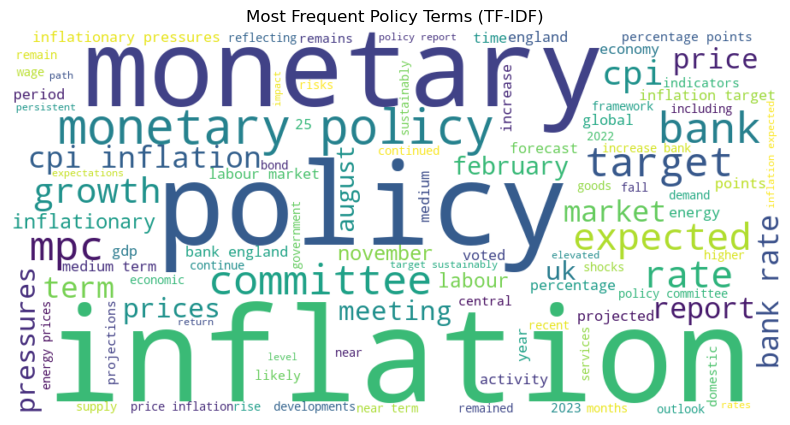

In [138]:

from wordcloud import WordCloud
vec = TfidfVectorizer(stop_words="english", ngram_range=(1,2), max_features=100)
X = vec.fit_transform(df["text"].fillna(""))
terms = pd.Series(X.toarray().mean(0), index=vec.get_feature_names_out()).sort_values(ascending=False)
wc = WordCloud(width=900, height=450, background_color="white", colormap="viridis")
wc.generate_from_frequencies(terms.to_dict())
plt.figure(figsize=(10,5)); plt.imshow(wc, interpolation="bilinear"); plt.axis("off"); plt.title("Most Frequent Policy Terms (TF-IDF)"); plt.show()

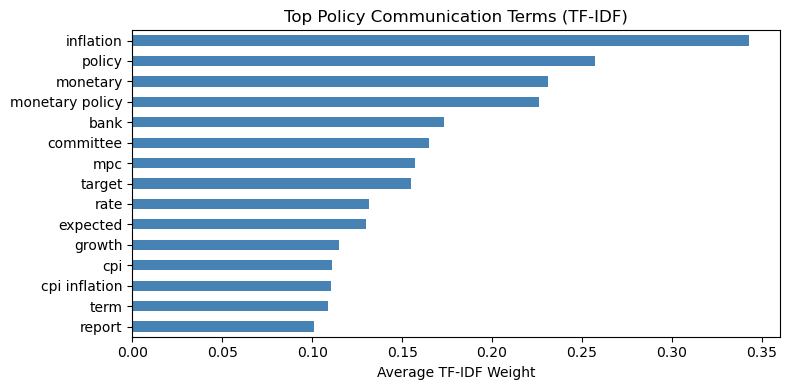

In [139]:
top_terms = terms.head(15)

plt.figure(figsize=(8,4))
top_terms.sort_values().plot(kind="barh", color="steelblue")
plt.xlabel("Average TF-IDF Weight")
plt.title("Top Policy Communication Terms (TF-IDF)")
plt.tight_layout()
plt.show()


The most characteristic language revolves around inflation targeting, monetary policy stance, and expectations management — exactly what we’d expect from MPC summaries. The TF-IDF confirms the LLM is scoring tone on a text base dominated by core policy concepts, not noise.

In [130]:
# # ground_truth: DataFrame with columns ["date","gt_score"] on same scale as df["mean"]
# ground_truth["date"] = pd.to_datetime(ground_truth["date"])
# merged = df.merge(ground_truth, on="date", how="inner")
# mse = ((merged["mean"] - merged["gt_score"])**2).mean()
# print("MSE vs economists:", round(mse, 4))
# plt.scatter(merged["gt_score"], merged["mean"]); plt.plot([0,1],[0,1]); plt.xlabel("GT"); plt.ylabel("LLM mean"); plt.title("Parity: LLM vs Ground truth"); plt.grid(True); plt.show()


# one glance table for the deck.
#### insight: structured, exportable snapshot per meeting.

In [131]:
cols = ["date","decision","bank_rate","cpi","mean","std","uncert_count","word_count"]
display(df[cols].sort_values("date").round(3))


,date,decision,bank_rate,cpi,mean,std,uncert_count,word_count
0,2021-02-04,hike,0.10,0.3,-1.00,0.00,1,762
1,2021-03-18,hike,0.10,2.0,-1.00,0.00,4,898
2,2021-05-06,unknown,NaN,NaN,-1.00,0.00,0,34
3,2021-06-24,cut,0.10,2.0,0.20,0.00,3,1025
4,2021-08-05,hike,0.10,2.5,-1.00,0.00,4,1182
5,2021-09-23,hike,0.10,4.0,1.00,0.00,5,1110
6,2021-11-04,hike,0.10,3.2,1.00,0.00,6,1176
7,2021-12-16,unknown,NaN,NaN,-1.00,0.00,0,110
8,2022-02-03,hike,0.50,5.1,1.00,0.00,5,1297
9,2022-03-17,hike,0.75,2.0,-1.00,0.00,7,964
